In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
tf.keras.backend.clear_session()

### Load packages

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd
import umap
import copy
import os, tempfile
from datetime import datetime

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Load dataset

In [6]:
dataset = 'fmnist'
dims = (28,28,1)
umap_prop = 0.0
num_classes = 10
PROJECTION_DIMS = 128
labels_per_class = 'full'


In [7]:
from tfumap.load_datasets import load_FMNIST, mask_labels

In [8]:
X_train, X_test, X_valid, Y_train, Y_test, Y_valid = load_FMNIST(flatten=False)
X_train.shape

(50000, 28, 28, 1)

In [9]:
if labels_per_class == "full":
    X_labeled = X_train
    Y_labeled = Y_train
    Y_masked = np.ones(len(Y_train))
else:
    X_labeled, Y_labeled, Y_masked = mask_labels(
        X_train, Y_train, labels_per_class=labels_per_class
    )

### Build umap graph

In [10]:
from tfumap.semisupervised import build_fuzzy_simplicial_set

In [11]:
n_neighbors = 15  # default = 15
umap_graph = build_fuzzy_simplicial_set(
    X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:]))),
    y=Y_masked,
    n_neighbors=n_neighbors,
)

### Build data iterators

In [12]:
from tfumap.umap import compute_cross_entropy, get_graph_elements
from tfumap.semisupervised import create_edge_iterator, create_validation_iterator, create_classification_iterator

In [13]:
n_epochs = 200
graph, epochs_per_sample, head, tail, weight, n_vertices = get_graph_elements(
            umap_graph, n_epochs
)
batch_size = np.min([n_vertices, 1000])
batch_size

1000

In [14]:
labeled_iter = create_classification_iterator(X_labeled, Y_labeled, batch_size=batch_size)

In [15]:
max_sample_repeats_per_epoch = 25
edge_iter, n_edges_per_epoch = create_edge_iterator(
    head,
    tail,
    weight,
    batch_size=batch_size,
    max_sample_repeats_per_epoch=max_sample_repeats_per_epoch,
)

In [16]:
data_valid, n_valid_samp = create_validation_iterator(X_valid, Y_valid, batch_size)

### Build network

In [20]:
encoder = tf.keras.Sequential()

encoder.add(tf.keras.layers.InputLayer(input_shape=dims))

# Normalization
encoder.add(tf.keras.layers.BatchNormalization())

# Conv + Maxpooling
encoder.add(tf.keras.layers.Convolution2D(64, (4, 4), padding='same', activation='relu'))
encoder.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Dropout
encoder.add(tf.keras.layers.Dropout(0.1))

# Conv + Maxpooling
encoder.add(tf.keras.layers.Convolution2D(64, (4, 4), activation='relu'))
encoder.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Dropout
encoder.add(tf.keras.layers.Dropout(0.3))

# Converting 3D feature to 1D feature Vektor
encoder.add(tf.keras.layers.Flatten())

# Fully Connected Layer
encoder.add(tf.keras.layers.Dense(256, activation='relu'))

# Dropout
encoder.add(tf.keras.layers.Dropout(0.5))

# Fully Connected Layer
encoder.add(tf.keras.layers.Dense(64, activation='relu'))

In [21]:
classifier = tf.keras.Sequential()
classifier.add(tf.keras.layers.InputLayer(input_shape=64))
# Normalization
classifier.add(tf.keras.layers.Dense(64, activation='relu'))
classifier.add(tf.keras.layers.BatchNormalization())
classifier.add(tf.keras.layers.Dense(num_classes, activation='softmax', name="predictions"))

In [22]:
embedder = tf.keras.Sequential()
embedder.add(tf.keras.Input(shape=(64)))
embedder.add(tf.keras.layers.Dense(units=64, activation="relu"))
embedder.add(tf.keras.layers.Dense(PROJECTION_DIMS, activation=None, name='z'))

In [23]:
encoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        1088      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        65600     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 64)         

### Create UMAP object

In [26]:
from tfumap.semisupervised_model import PUMAP

In [27]:
tf.keras.backend.clear_session()
tf.compat.v1.global_variables_initializer()
tf.compat.v1.reset_default_graph()

In [28]:
### Initialize model
model = PUMAP(
    min_dist = 0.0,
    negative_sample_rate = 5, # how many negative samples per positive
    optimizer=tf.keras.optimizers.Adam(1e-4), # cross-entropy optimizer
    encoder=encoder,
    embedder=embedder,
    classifier=classifier,
    umap_prop=umap_prop
    
)

### plotting results

In [29]:
from tfumap.semisupervised_plotting import plot_umap_classif_results, plot_results, get_decision_contour

No objects to concatenate


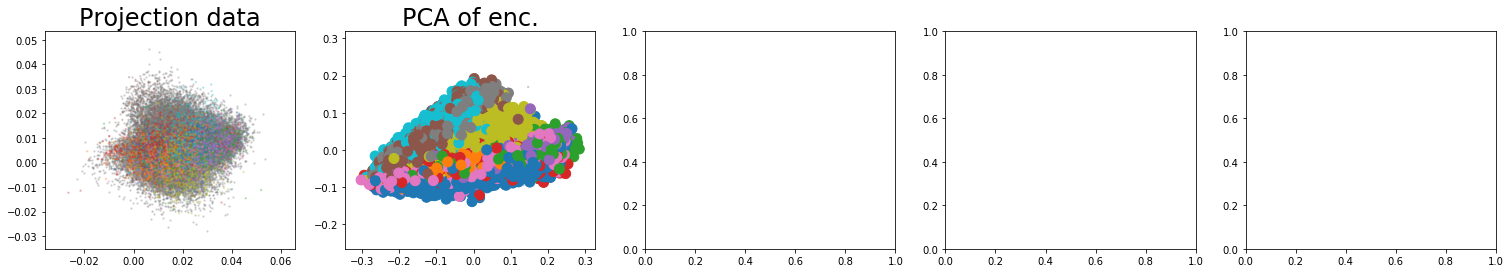

In [30]:
plot_umap_classif_results(model, X_valid, Y_valid, X_train, X_labeled, Y_labeled, batch_size, cmap='tab10', cmap2='tab10')

### Train model

In [31]:
batch = 0; epoch = 0
N_EPOCHS = 10 # total number of epochs
SAMPLE_EPOCHS = np.linspace(0, N_EPOCHS-1, 10).astype('int') # how often to plot
print(SAMPLE_EPOCHS[:10])
BATCHES_PER_EPOCH = int(n_edges_per_epoch / batch_size)
TOTAL_BATCHES = BATCHES_PER_EPOCH * N_EPOCHS

[0 1 2 3 4 5 6 7 8 9]


In [32]:
#z_valid = UMAP(verbose=True).fit_transform(latent_valid.numpy())

In [ ]:
# label and classify simultaneously...

In [34]:
for X, y in tqdm(labeled_iter):
    losses = model.train(batch_to=None, batch_from=None, X=X, y=y)

KeyboardInterrupt: 

batch: 9000


9000


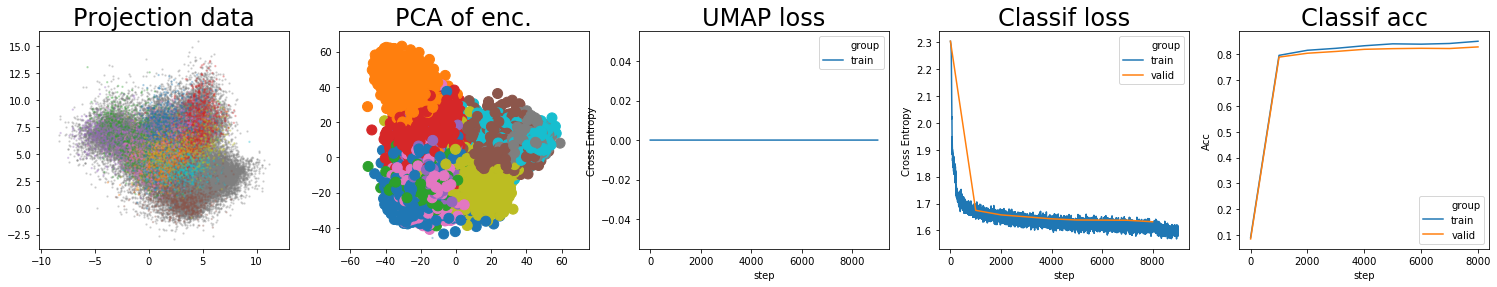

batch: 10000


10000


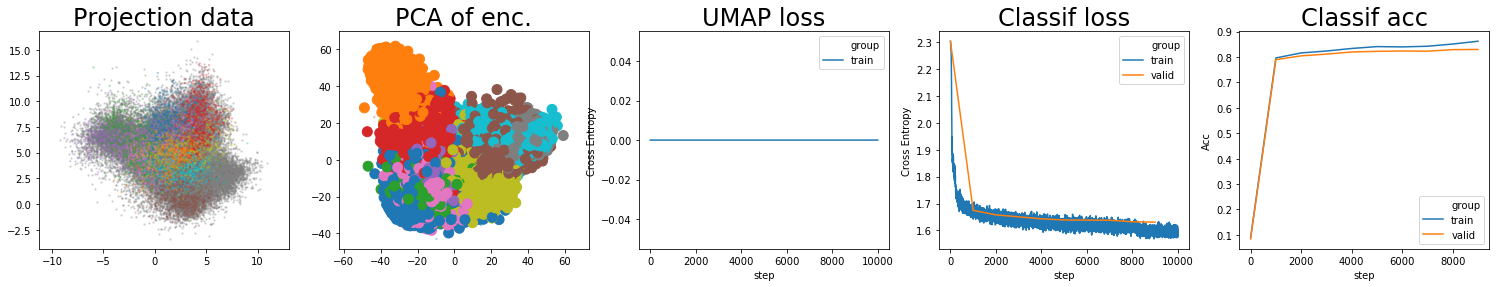

batch: 11000


11000


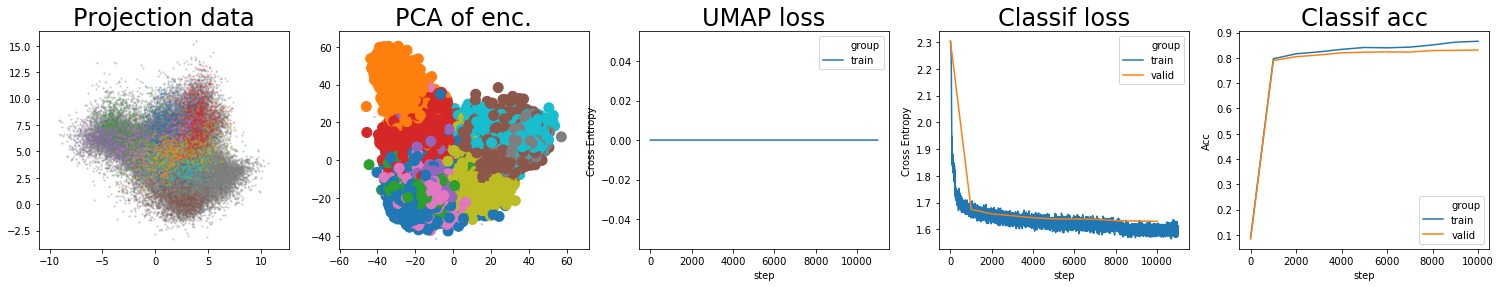

batch: 12000


12000


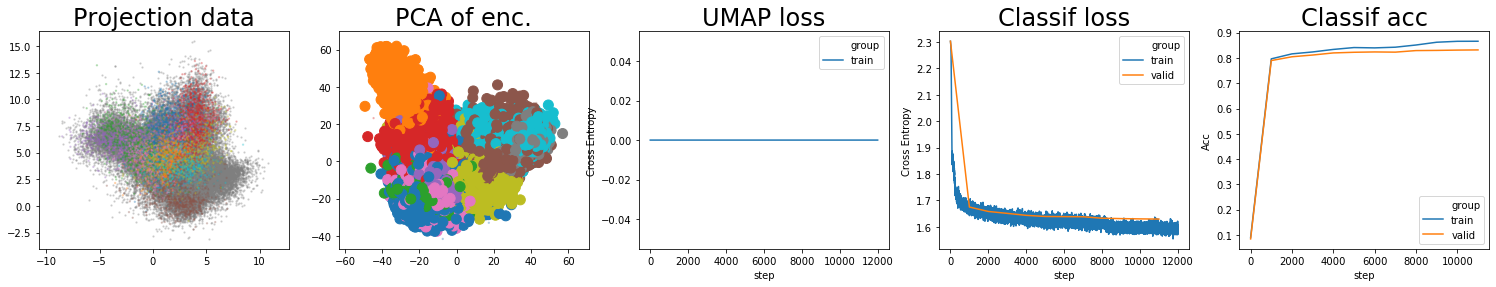

batch: 13000


13000


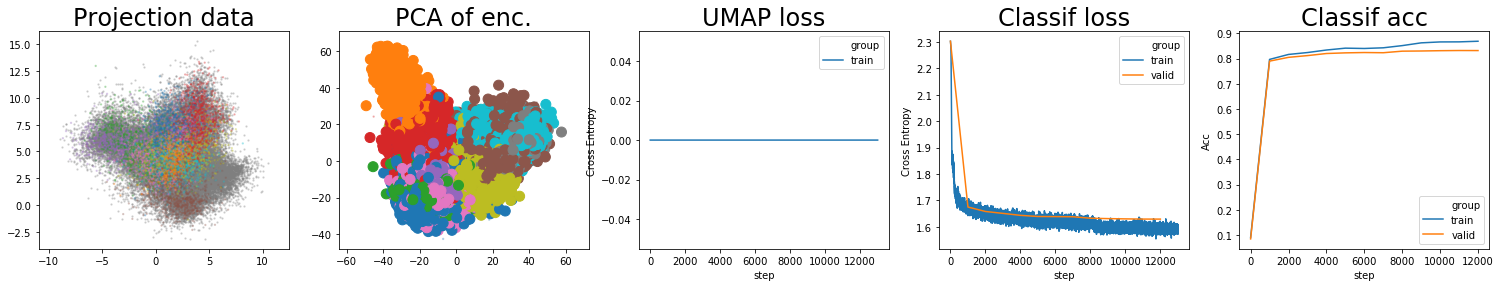

batch: 14000


14000


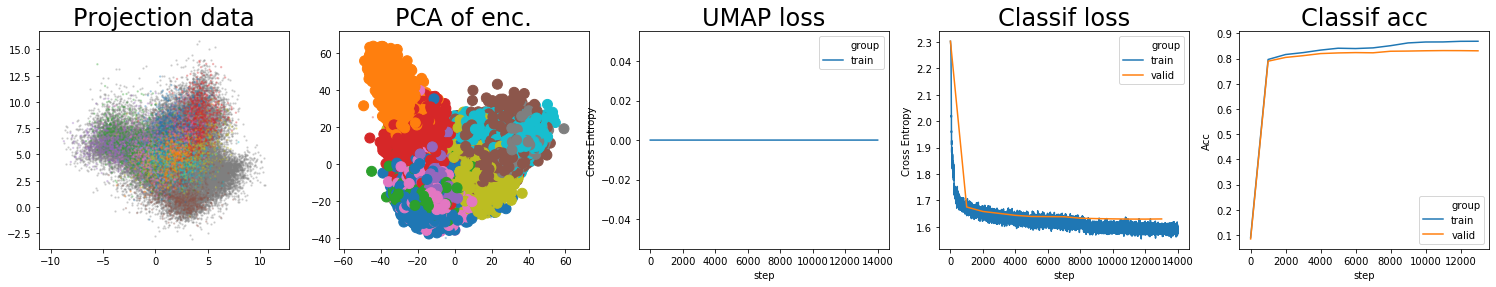

batch: 15000


15000


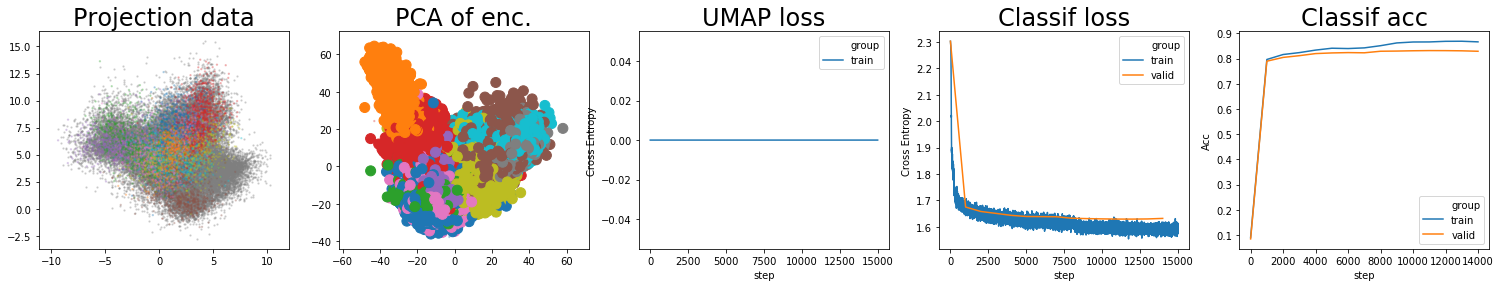

batch: 16000


16000


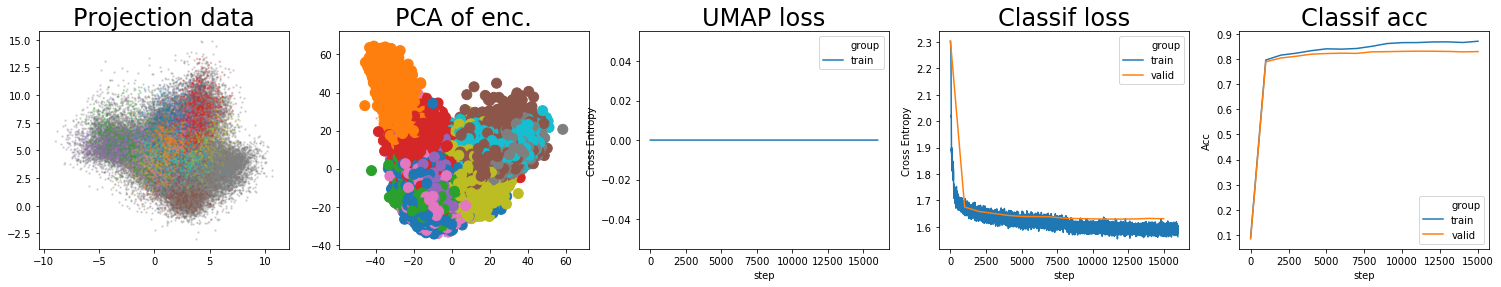

KeyboardInterrupt: 

In [35]:
for edge_epoch, epoch in tqdm(zip(edge_iter, np.arange(N_EPOCHS)), total=N_EPOCHS):
    
    # train
    for bi, ((batch_to, batch_from), (X, y)) in tqdm(
        enumerate(zip(edge_epoch, labeled_iter)), total=BATCHES_PER_EPOCH, leave=False
    ):
        if batch %1000 ==0:
            print("batch: {}".format(batch))
            plot_umap_classif_results(model, X_valid, Y_valid, X_train, X_labeled, Y_labeled, batch_size, cmap='tab10', cmap2='tab10')
            # validation loss
            classif_loss = model.get_dataset_loss(data_valid)
            model.write_losses(
                    batch=batch, classif_loss=classif_loss, umap_loss=None, train=False
                )
            model.write_acc(X_valid, Y_valid, batch, train=False)
            model.write_acc(X_labeled, Y_labeled, batch, train=True)
        
        
        batch_to = X_train[batch_to]
        batch_from = X_train[batch_from]
        # train model
        losses = model.train(batch_to=batch_to, batch_from=batch_from, X=X, y=y)
        model.write_losses(
            batch=batch, classif_loss=losses[3], umap_loss=losses[2], train=True
        )
        
        batch += 1


In [36]:
classif_loss = model.get_dataset_loss(data_valid)
tf.reduce_mean(classif_loss).numpy()

1.6318827

In [37]:
predictions = model.classify_data(X_labeled)
tf.keras.metrics.Accuracy()(predictions, Y_labeled).numpy()

0.86748

In [38]:
predictions = model.classify_data(X_valid)
tf.keras.metrics.Accuracy()(predictions, Y_valid).numpy()

0.8294

In [39]:
predictions = model.classify_data(X_test)
tf.keras.metrics.Accuracy()(predictions, Y_test).numpy()

0.8276

In [36]:
predictions

<tf.Tensor: shape=(10000,), dtype=int64, numpy=array([9, 2, 1, ..., 8, 1, 5])>

In [ ]:
tf.argmax(model.classifier(model.encoder(X_train[:100])), axis=1)

In [ ]:
from tfumap.umap import retrieve_tensors
import seaborn as sns

from tfumap.semisupervised_plotting import embed_data

In [ ]:
loss_df = retrieve_tensors(model.tensorboard_logdir)
loss_df['step'] +=1
loss_df

In [ ]:
loss_df.variable.unique()

In [ ]:
plot_umap_classif_results(model, X_valid, Y_valid, X_train, X_labeled, Y_labeled, batch_size, cmap='tab10', cmap2='tab10')

In [ ]:
sns.lineplot(
    x="step",
    y="val",
    hue="group",
    data=loss_df[loss_df.variable == "umap_loss"],
    ci=None,
)

In [ ]:
sns.lineplot(
    x="step",
    y="val",
    hue="group",
    data=loss_df[loss_df.variable == "acc_classif"],
    ci=None,
)